# CATEGORY CLASSIFICATION

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# load data
data = pd.read_csv('./input/abcnews-date-text.csv')
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1244184 non-null  int64 
 1   headline_text  1244184 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.0+ MB


In [7]:
data = data.rename(columns={'headline_text': 'text'})
data['text'] = data['text'].astype(str)

In [8]:
data[data['text'].duplicated(keep=False)].sort_values('text').head(10)

,publish_date,text
116298,20040920,10 killed in pakistan bus crash
57967,20031129,10 killed in pakistan bus crash
911080,20141023,110 with barry nicholls
672958,20120217,110 with barry nicholls
748629,20121214,110 with barry nicholls
676423,20120302,110 with barry nicholls
897042,20140820,110 with barry nicholls episode 15
826828,20131017,110 with barry nicholls episode 15
826829,20131017,110 with barry nicholls episode 16
898353,20140826,110 with barry nicholls episode 16


In [9]:
data = data.drop_duplicates('text').reset_index(drop=True)

In [10]:
data = data.head(50000)
data.head()

,publish_date,text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publish_date  50000 non-null  int64 
 1   text          50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


# 1. Labelling 
- through Natural Language Processing(NLP) Libraries
- https://www.kaggle.com/code/ahmadalijamali/headline-news-classification-with-bert
- https://www.snorkel.org/use-cases/01-spam-tutorial#3-writing-more-labeling-functions

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt_tab')
import string

import numpy as np
import torch

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zoezh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
punc = string.punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zoezh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# reference: https://www.snorkel.org/use-cases/01-spam-tutorial#3-writing-more-labeling-functions
# list of positive keywords/negative keywords
# this list can be further extended 

# list of labeling functions
categories ={
    "business and economy":[
        "economy","markets","trades","financial news","stocks","banking sector","investments",
        "fiscal policy","economic growth","recession","unemployment rates","government budget",
        "trade deficit","inflation rates","financial regulation","IPO","mergers","acquisitions"
    ],
    "entertainment and arts":[
        "movies","music industry","television shows","concerts","celebrities","theatre","arts",
        "literature","film festivals","award shows","celebrity gossip","entertainment news",
        "cultural events","art exhibitions","book releases","box office"
    ],
    "politics and law":[
        "elections","government policies","senatorial","legislation","diplomatic relations",
        "political campaigns", "law enforcement","legal system", "justice system","judiciary",
        "political debates","international relations","civil rights","policy making","political scandals"
    ],
    "sports":[
        "matches","tournaments","athletics","race","victories","sports teams","world cup",
        "olympics","championships","sports news","athlete profiles","sports injuries",
        "team standings","sports statistics","coaching changes","player transfers"
    ],
    "science and technology":[
        "scientific advancement","gadgets","internet security","tech","innovations",
        "software development","hardware upgrades","scientific research","new discoveries",
        "experimental","theoretical studies","biological findings","physics research",
        "artificial intelligence","machine learning","robotics","space exploration","environmental tech"
    ],
    "health and medicine":[
        "well-being","healthcare","medical breakthroughs","epidemics","treatments","public health",
        "mental health","health systems","hospitals","medical research","vaccination","disease prevention",
        "health policy","fitness","nutrition","health technology","pharmaceuticals"
    ],
    "environment and energy":[
        "climate change","renewable energy","conservation efforts","environmental protection",
        "wildlife conservation","pollution control","sustainable living","clean energy","recycling",
        "deforestation","carbon footprint","green technology","environmental policy","biodiversity",
        "eco-friendly products"
    ],
    "crime and justice":[
        "criminal activity","crime news","law and order","trials","court cases","legal debates",
        "criminal investigations","judiciary news","crime prevention","forensic science","public safety",
        "corruption","fraud","theft","homicide","law enforcement agencies"
    ]
}

category_names = list(categories.keys())
category_keywords = [" ".join(keywords) for keywords in categories.values()]
# print(category_names)
# print(category_keywords)

In [15]:
# if contain above keywords, then return the category
def get_category(text):
    for i, keywords in enumerate(category_keywords):
        if any(word in text for word in keywords.split()):
            return category_names[i]
    return "others"

# get category for each text
data['actual_category'] = data['text'].apply(get_category)
data.head()


,publish_date,text,actual_category
0,20030219,aba decides against community broadcasting lic...,others
1,20030219,act fire witnesses must be aware of defamation,others
2,20030219,a g calls for infrastructure protection summit,environment and energy
3,20030219,air nz staff in aust strike for pay rise,others
4,20030219,air nz strike to affect australian travellers,others


In [16]:
# check the distribution of categories
data['actual_category'].value_counts()

actual_category
others                    34816
crime and justice          4138
entertainment and arts     2368
science and technology     2213
sports                     1911
business and economy       1467
politics and law           1157
health and medicine         979
environment and energy      951
Name: count, dtype: int64

# 2. Preprocessing

In [17]:
# Normalization: Con vert all the headlines to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,publish_date,text,actual_category
0,20030219,aba decides against community broadcasting lic...,others
1,20030219,act fire witnesses must be aware of defamation,others
2,20030219,a g calls for infrastructure protection summit,environment and energy
3,20030219,air nz staff in aust strike for pay rise,others
4,20030219,air nz strike to affect australian travellers,others


In [18]:
# Tokenization: Split the text into individual words or tokens
data['text'] = data['text'].apply(word_tokenize)
data.head()

,publish_date,text,actual_category
0,20030219,"[aba, decides, against, community, broadcastin...",others
1,20030219,"[act, fire, witnesses, must, be, aware, of, de...",others
2,20030219,"[a, g, calls, for, infrastructure, protection,...",environment and energy
3,20030219,"[air, nz, staff, in, aust, strike, for, pay, r...",others
4,20030219,"[air, nz, strike, to, affect, australian, trav...",others


In [19]:
# Stop Word Removal: Remove commonly used words (such as "the", "is", "in")
data['text'] = data['text'].apply(lambda x: [item for item in x if item not in stop_words])
data.head()

,publish_date,text,actual_category
0,20030219,"[aba, decides, community, broadcasting, licence]",others
1,20030219,"[act, fire, witnesses, must, aware, defamation]",others
2,20030219,"[g, calls, infrastructure, protection, summit]",environment and energy
3,20030219,"[air, nz, staff, aust, strike, pay, rise]",others
4,20030219,"[air, nz, strike, affect, australian, travellers]",others


In [20]:
# Stemming: Apply stemming to reduce words to their base or root form.
# For example, "running" would be stemmed to "run". This helps in generalizing the text and reducing the complexity of the dataset.
ps = PorterStemmer()
data['text'] = data['text'].apply(lambda x: [ps.stem(item) for item in x])
data.head()

,publish_date,text,actual_category
0,20030219,"[aba, decid, commun, broadcast, licenc]",others
1,20030219,"[act, fire, wit, must, awar, defam]",others
2,20030219,"[g, call, infrastructur, protect, summit]",environment and energy
3,20030219,"[air, nz, staff, aust, strike, pay, rise]",others
4,20030219,"[air, nz, strike, affect, australian, travel]",others


In [21]:
# Reconstruction: reconstruct the processed tokens back into a string format
data['text'] = data['text'].apply(lambda x: ' '.join(x))

data.head()

,publish_date,text,actual_category
0,20030219,aba decid commun broadcast licenc,others
1,20030219,act fire wit must awar defam,others
2,20030219,g call infrastructur protect summit,environment and energy
3,20030219,air nz staff aust strike pay rise,others
4,20030219,air nz strike affect australian travel,others


In [22]:
preprocessed_headlines = data['text']

# 3. Modeling


In [23]:
from transformers import BertTokenizer, BertModel, BartTokenizer, BartModel, BartForConditionalGeneration, BartConfig, BartForSequenceClassification
from transformers import GPT2TokenizerFast,GPT2Model, AutoTokenizer, AutoModel, RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [24]:
# Load Models
bert_tokenizer, bert_model = BertTokenizer.from_pretrained("bert-base-uncased"), BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa").cuda()
bart_tokenizer, bart_model = AutoTokenizer.from_pretrained("facebook/bart-base"), BartForConditionalGeneration.from_pretrained("facebook/bart-base").cuda()
gpt2_tokenizer, gpt2_model = GPT2TokenizerFast.from_pretrained("gpt2"), GPT2Model.from_pretrained("gpt2")
roberta_tokenizer, roberta_model = RobertaTokenizer.from_pretrained("roberta-base"), RobertaModel.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 BERT - Modelling

In [25]:
# Use mixed precision for inference
inputs_categories = bert_tokenizer(category_keywords, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')

with torch.no_grad():
    with torch.cuda.amp.autocast():
        outputs_categories = bert_model(**inputs_categories)

category_embeddings = outputs_categories.last_hidden_state.mean(dim=1).cpu()

category_embeddings.shape

# delete cuda memory
del inputs_categories, outputs_categories
torch.cuda.empty_cache()

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


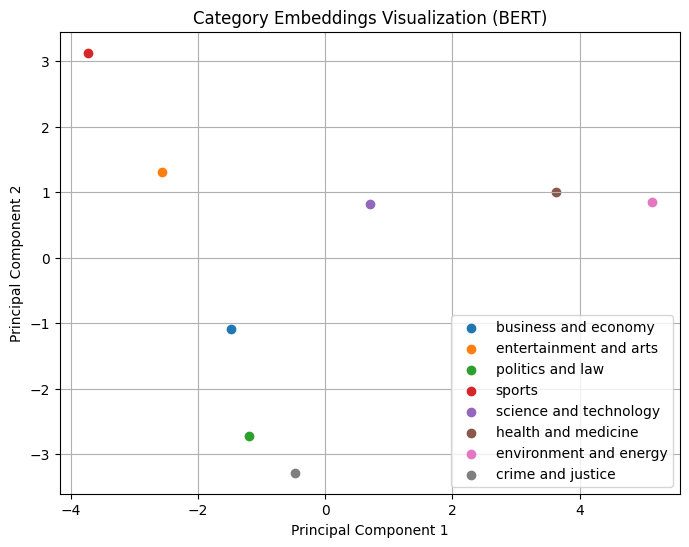

In [26]:
# Visualize category embeddings using PCA
pca = PCA(n_components=min(2, category_embeddings.shape[0]))  # Ensure n_components <= input size
reduced_embeddings = pca.fit_transform(category_embeddings.numpy())

plt.figure(figsize=(8, 6))
for i, label in enumerate(category_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
plt.title(f"Category Embeddings Visualization (BERT)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


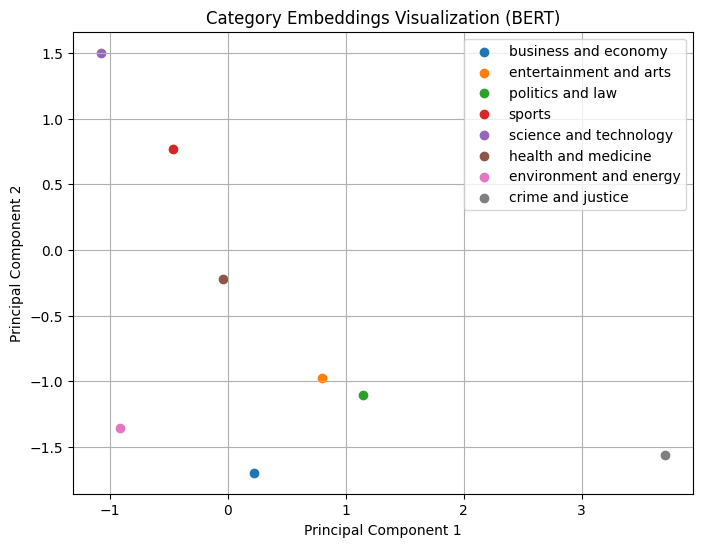

In [27]:
batch_size = 100  # Adjust batch size based on your GPU memory
headline_embeddings = []

for i in range(0, len(preprocessed_headlines), batch_size):
    batch_headlines = preprocessed_headlines[i:i+batch_size]
    inputs_headlines = bert_tokenizer(batch_headlines.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs_headlines = bert_model(**inputs_headlines)
    batch_embeddings = outputs_headlines.last_hidden_state.mean(dim=1).cpu()
    headline_embeddings.append(batch_embeddings)

headline_embeddings = torch.cat(headline_embeddings)

del inputs_headlines, outputs_headlines
torch.cuda.empty_cache()

# Visualize category embeddings using PCA
pca = PCA(n_components=min(2, headline_embeddings.shape[0]))  # Ensure n_components <= input size
reduced_embeddings = pca.fit_transform(headline_embeddings.numpy())

plt.figure(figsize=(8, 6))
for i, label in enumerate(category_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
plt.title(f"Category Embeddings Visualization (BERT)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Calculate similarity and classify
similarities = cosine_similarity(headline_embeddings, category_embeddings)
predicted_categories = [category_names[idx] for idx in np.argmax(similarities, axis=1)]

# Store results
data['BERT'] = predicted_categories

print(f"Predictions for BERT model generated successfully!")

Predictions for BERT model generated successfully!


In [29]:
data['BERT'].value_counts()

BERT
sports                    32260
business and economy      11012
crime and justice          3330
entertainment and arts     1393
science and technology     1266
health and medicine         320
politics and law            274
environment and energy      145
Name: count, dtype: int64

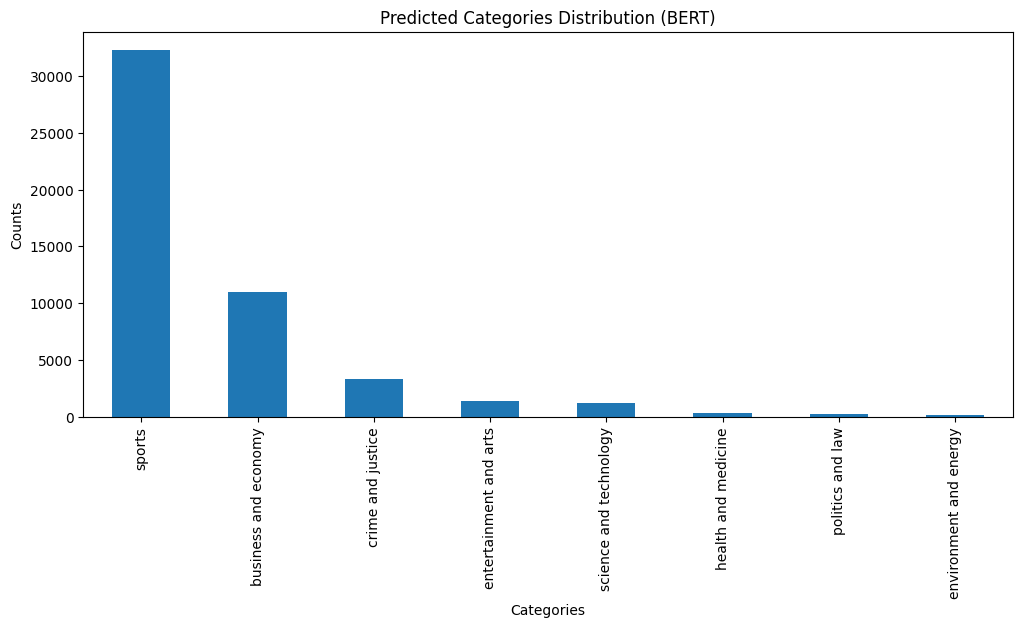

In [30]:
# bar chart of predicted categories distribution
plt.figure(figsize=(12, 5))
plt.title('Predicted Categories Distribution (BERT)')
data['BERT'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

## 3.2 BART - Modeling

In [31]:
inputs_categories = bart_tokenizer(category_keywords, return_tensors='pt', padding=True, truncation=True, max_length=512).to(bart_model.device)
with torch.no_grad():
    outputs_categories = bart_model(**inputs_categories)
category_embeddings = outputs_categories.encoder_last_hidden_state.mean(dim=1).cpu()

In [47]:
category_embeddings.shape

torch.Size([8, 768])

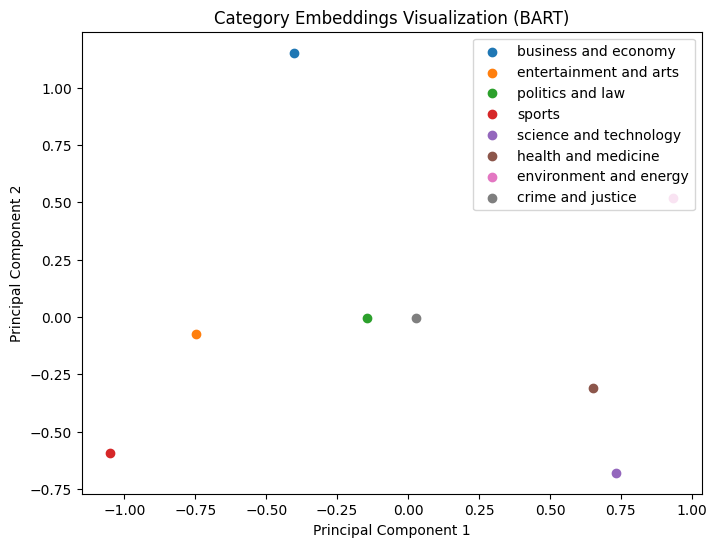

In [48]:
pca = PCA(n_components=min(2, category_embeddings.shape[0]))
reduced_embeddings = pca.fit_transform(category_embeddings.numpy())
plt.figure(figsize=(8, 6))
for i, label in enumerate(category_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
plt.title("Category Embeddings Visualization (BART)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [49]:
batch_size = 100  # Adjust batch size based on your GPU memory
headline_embeddings = []

for i in range(0, len(preprocessed_headlines), batch_size):
    batch_headlines = preprocessed_headlines[i:i+batch_size]
    inputs_headlines = bart_tokenizer(batch_headlines.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs_headlines = bart_model(**inputs_headlines)
    batch_embeddings = outputs_headlines.encoder_last_hidden_state.mean(dim=1).cpu()
    headline_embeddings.append(batch_embeddings)

headline_embeddings = torch.cat(headline_embeddings)

del inputs_headlines, outputs_headlines
torch.cuda.empty_cache()

In [50]:
headline_embeddings.shape

torch.Size([50000, 768])

In [51]:
# Calculate similarity and classify
similarities = cosine_similarity(headline_embeddings, category_embeddings)
predicted_categories = [category_names[idx] for idx in np.argmax(similarities, axis=1)]

# Store results
data['BART'] = predicted_categories

print(f"Predictions for BART model generated successfully!")

Predictions for BART model generated successfully!


In [52]:
# statistics of BERT prediction
data.head()


,publish_date,text,actual_category,GPT2_pred,RoBERTa_pred,BART
0,20030219,aba decid commun broadcast licenc,others,sports,science and technology,sports
1,20030219,act fire wit must awar defam,others,sports,science and technology,sports
2,20030219,g call infrastructur protect summit,environment and energy,sports,science and technology,entertainment and arts
3,20030219,air nz staff aust strike pay rise,others,sports,science and technology,sports
4,20030219,air nz strike affect australian travel,others,sports,entertainment and arts,sports


In [53]:
data['BART'].value_counts()

BART
sports                    43214
entertainment and arts     5854
business and economy        928
health and medicine           2
crime and justice             1
environment and energy        1
Name: count, dtype: int64

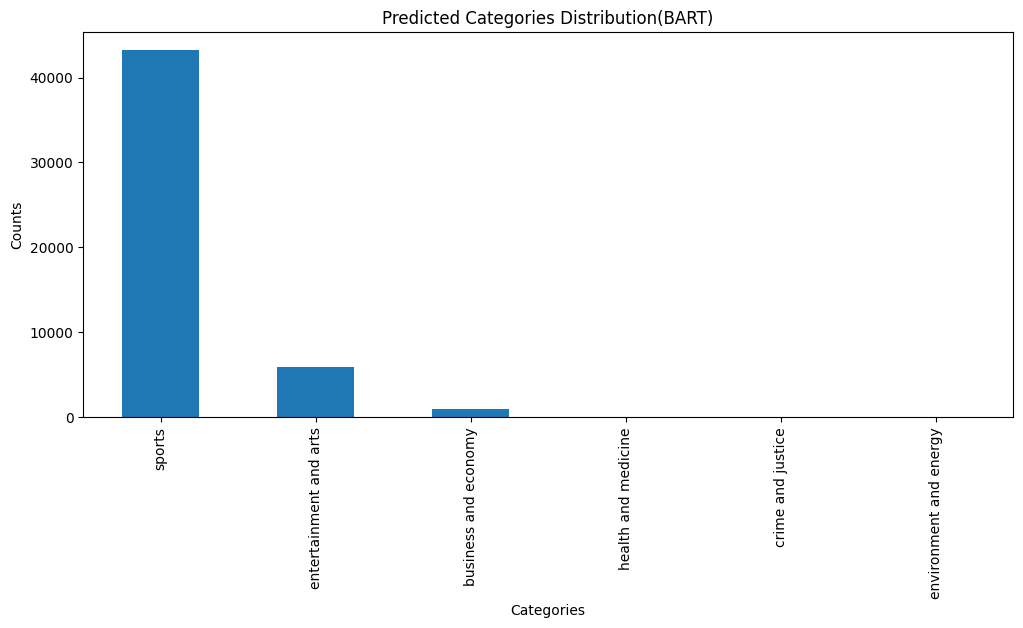

In [54]:
# bar chart of predicted categories distribution
plt.figure(figsize=(12, 5))
plt.title('Predicted Categories Distribution(BART)')
data['BART'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

## 3.3 GPT-2

In [55]:
# Set pad_token to eos_token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Use mixed precision for inference
# Move inputs to the same device as the model
inputs_categories = gpt2_tokenizer(category_keywords, return_tensors='pt', padding=True, truncation=True, max_length=512).to(gpt2_model.device)

# Ensure model and input are on the same device
with torch.no_grad():
    with torch.cuda.amp.autocast():
        outputs_categories = gpt2_model(**inputs_categories)

category_embeddings = outputs_categories.last_hidden_state.mean(dim=1).cpu()


category_embeddings.shape

# delete cuda memory
del inputs_categories, outputs_categories
torch.cuda.empty_cache()

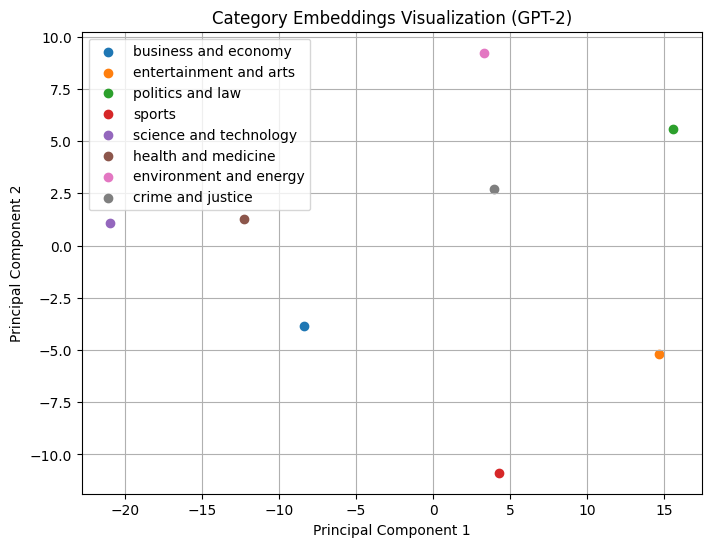

In [56]:
pca = PCA(n_components=min(2, category_embeddings.shape[0]))
reduced_embeddings = pca.fit_transform(category_embeddings.numpy())
plt.figure(figsize=(8, 6))
for i, label in enumerate(category_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
plt.title("Category Embeddings Visualization (GPT-2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
batch_size = 100  # Adjust batch size based on your GPU memory
headline_embeddings = []

for i in range(0, len(preprocessed_headlines), batch_size):
    batch_headlines = preprocessed_headlines[i:i+batch_size]
    # Ensure inputs_headlines is on the same device as the model
    inputs_headlines = gpt2_tokenizer(batch_headlines.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512).to(gpt2_model.device)

    # Generate embeddings
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs_headlines = gpt2_model(**inputs_headlines)

    batch_embeddings = outputs_headlines.last_hidden_state.mean(dim=1).cpu()
    headline_embeddings.append(batch_embeddings)
    if (i+batch_size) % 2000 == 0:
        print(f"Processed {i + batch_size} headlines")

print("Finish processing all headlines!")
headline_embeddings = torch.cat(headline_embeddings)

del inputs_headlines, outputs_headlines
torch.cuda.empty_cache()

Processed 2000 headlines
Processed 4000 headlines
Processed 6000 headlines
Processed 8000 headlines
Processed 10000 headlines
Processed 12000 headlines
Processed 14000 headlines
Processed 16000 headlines
Processed 18000 headlines
Processed 20000 headlines
Processed 22000 headlines
Processed 24000 headlines
Processed 26000 headlines
Processed 28000 headlines
Processed 30000 headlines
Processed 32000 headlines
Processed 34000 headlines
Processed 36000 headlines
Processed 38000 headlines
Processed 40000 headlines
Processed 42000 headlines
Processed 44000 headlines
Processed 46000 headlines
Processed 48000 headlines
Processed 50000 headlines
Finish processing all headlines!


In [58]:
similarities = cosine_similarity(headline_embeddings, category_embeddings)
predicted_categories = [category_names[idx] for idx in np.argmax(similarities, axis=1)]
data['GPT2_pred'] = predicted_categories

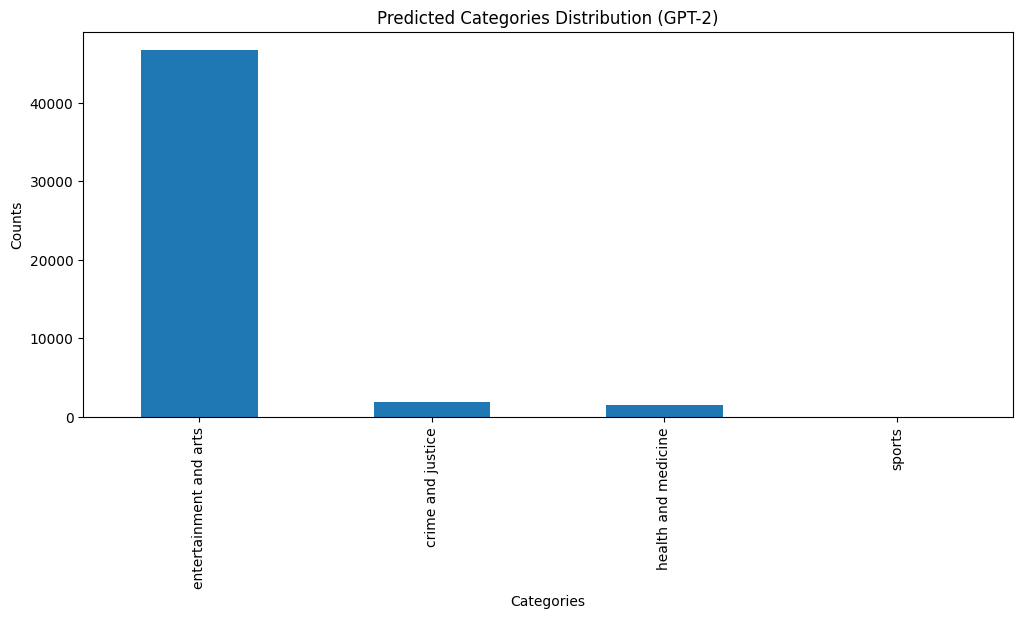

In [59]:
# bar chart of predicted categories distribution
plt.figure(figsize=(12, 5))
plt.title('Predicted Categories Distribution (GPT-2)')
data['GPT2_pred'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

## 3.4 RoBERTa

In [32]:
inputs_categories = roberta_tokenizer(category_keywords, return_tensors='pt', padding=True, truncation=True, max_length=512)
with torch.no_grad():
    outputs_categories = roberta_model(**inputs_categories)
category_embeddings = outputs_categories.last_hidden_state.mean(dim=1).cpu()

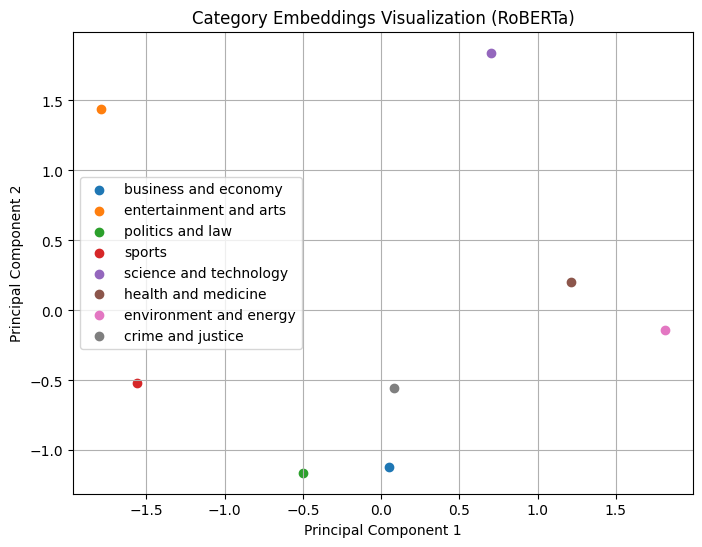

In [33]:
pca = PCA(n_components=min(2, category_embeddings.shape[0]))
reduced_embeddings = pca.fit_transform(category_embeddings.numpy())
plt.figure(figsize=(8, 6))
for i, label in enumerate(category_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
plt.title("Category Embeddings Visualization (RoBERTa)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
batch_size = 100  # Adjust batch size based on your GPU memory
headline_embeddings = []

for i in range(0, len(preprocessed_headlines), batch_size):
    batch_headlines = preprocessed_headlines[i:i+batch_size]
    # Ensure inputs_headlines is on the same device as the model
    inputs_headlines = roberta_tokenizer(batch_headlines.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512).to(gpt2_model.device)

    # Generate embeddings
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs_headlines = roberta_model(**inputs_headlines)

    batch_embeddings = outputs_headlines.last_hidden_state.mean(dim=1).cpu()
    headline_embeddings.append(batch_embeddings)
    if (i+batch_size) % 2000 == 0:
        print(f"Processed {i + batch_size} headlines")

print("Finish processing all headlines!")
headline_embeddings = torch.cat(headline_embeddings)

del inputs_headlines, outputs_headlines
torch.cuda.empty_cache()

Processed 2000 headlines
Processed 4000 headlines
Processed 6000 headlines
Processed 8000 headlines
Processed 10000 headlines
Processed 12000 headlines
Processed 14000 headlines
Processed 16000 headlines
Processed 18000 headlines
Processed 20000 headlines
Processed 22000 headlines
Processed 24000 headlines
Processed 26000 headlines
Processed 28000 headlines
Processed 30000 headlines
Processed 32000 headlines
Processed 34000 headlines
Processed 36000 headlines
Processed 38000 headlines
Processed 40000 headlines
Processed 42000 headlines
Processed 44000 headlines
Processed 46000 headlines
Processed 48000 headlines
Processed 50000 headlines
Finish processing all headlines!


In [35]:
similarities = cosine_similarity(headline_embeddings, category_embeddings)
predicted_categories = [category_names[idx] for idx in np.argmax(similarities, axis=1)]
data['RoBERTa_pred'] = predicted_categories

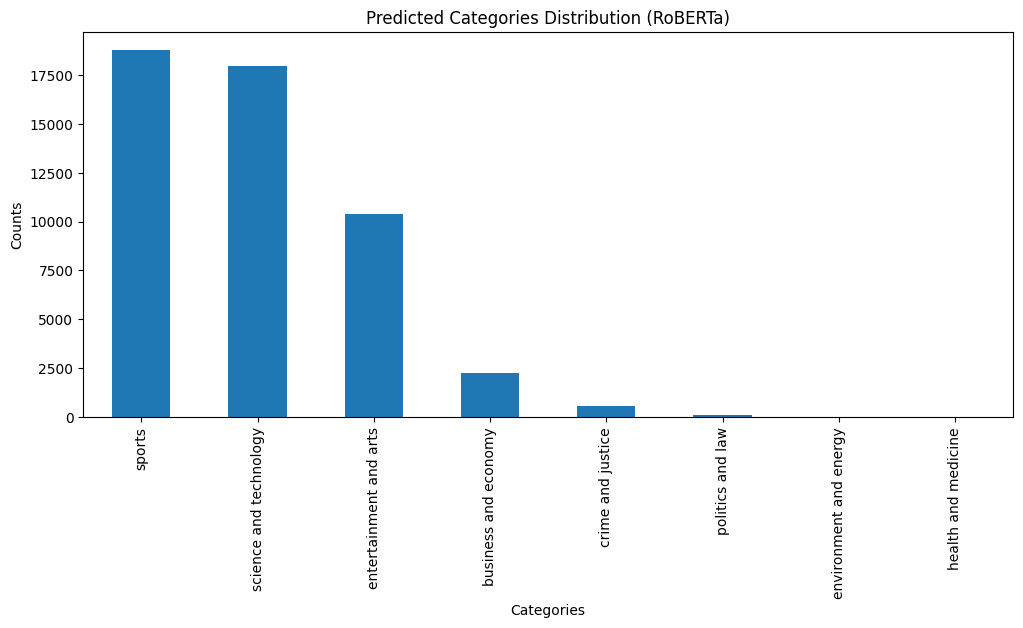

In [36]:
# bar chart of predicted categories distribution
plt.figure(figsize=(12, 5))
plt.title('Predicted Categories Distribution (RoBERTa)')
data['RoBERTa_pred'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

## 3.5 Ensemble Method - BERT+RoBERTa

In [37]:
def weighted_voting(bert_preds, roberta_preds, bert_weight=0.4, roberta_weight=0.6):
    ensemble_preds = []
    for b, r in zip(bert_preds, roberta_preds):
        weighted_scores = {
            b: bert_weight,
            r: roberta_weight
        }
        # Select category with the highest weighted score
        most_common = max(weighted_scores, key=weighted_scores.get)
        ensemble_preds.append(most_common)
    return ensemble_preds

In [39]:
ensemble_pred = weighted_voting(data['BERT'], data['RoBERTa_pred'])
data['Ensemble_predicted_category'] = ensemble_pred

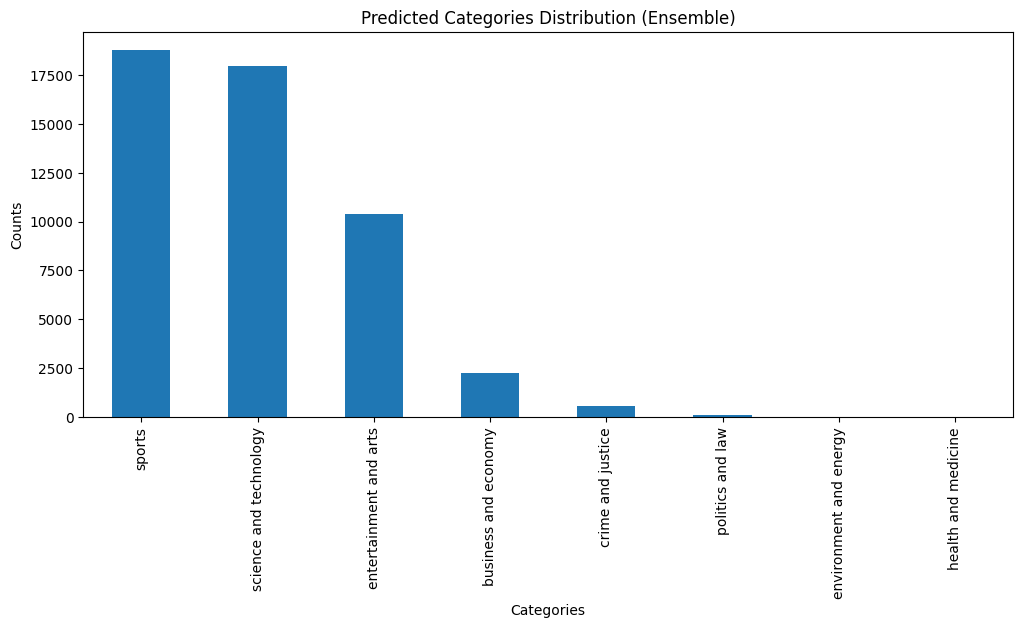

In [40]:
plt.figure(figsize=(12, 5))
plt.title('Predicted Categories Distribution (Ensemble)')
data['Ensemble_predicted_category'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()